In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
import tabulate
from IPython.display import display, HTML, Markdown
from scipy.spatial.distance import cdist as dist
from notebook_functions import open_file_dialog, read_h5_data, blue, orange
import scipy.signal
from scipy.fftpack import fft, ifft, fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable

############# SCRIPT PARAMETERS #############

data_set = 'vdc_8'
rho = 1000.
c = 1500.
r = 0.05
angles = [-10, 10, 21]
flow = 5e6
fhigh = 10e6
forder = 6

#############################################

path_to_file = open_file_dialog()

parameters = {'File': path_to_file,
              'Dataset': data_set,
              'Density (kg/m^3)': rho,
              'Sound speed (m/s)': c,
              'Radius (m)': r,
              'Angles (deg)': angles,
              'Filter low (MHz)': flow/1e6,
              'Filter high (MHz)': fhigh/1e6,
              'Filter order': forder
             }

# display(Markdown('### <center> Notebook parameters </center>'))
display(HTML('<center>' + tabulate.tabulate(parameters.items(), tablefmt='html') + '</center>'))

File,D:/Data/full_vernier_tx_9x9_data.h5
Dataset,vdc_8
Density (kg/m^3),1000.0
Sound speed (m/s),1500.0
Radius (m),0.05
Angles (deg),"[-10, 10, 21]"
Filter low (MHz),5.0
Filter high (MHz),10.0
Filter order,6


In [2]:
## load data from file
if path_to_file is not None:
    data = read_h5_data(path_to_file, data_set, add_zero_freq=True, minimal=True)

<IPython.core.display.Javascript object>


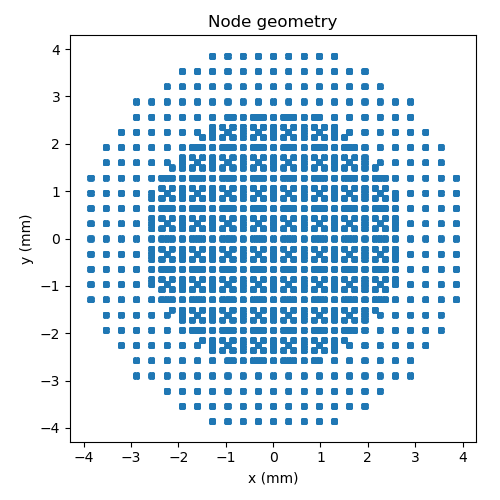

In [3]:
## get nodes
nodes = data['nodes']

## node plot
plt.figure(figsize=(5,5))
plt.plot(nodes[:,0]/1e-3, nodes[:,1]/1e-3, '.', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Node geometry');
plt.tight_layout()

<IPython.core.display.Javascript object>


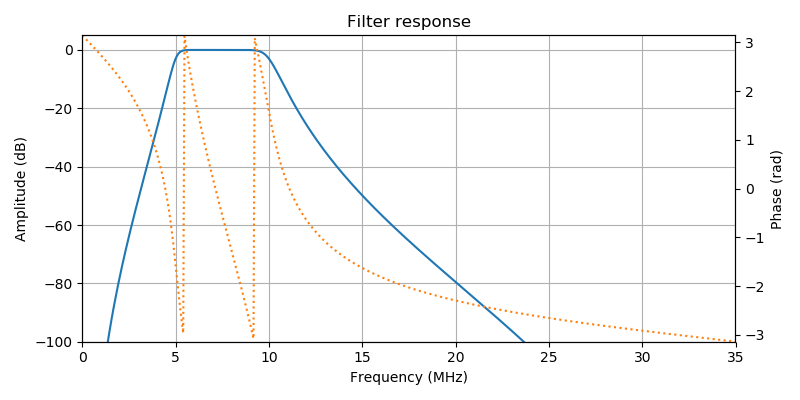

In [4]:
freqs = data['freqs']
nfreqs = len(freqs)

## create bandpass filter
fs = (freqs[1] - freqs[0])*nfreqs*2
nyq = fs / 2
f1 = flow / nyq
f2 = fhigh / nyq
order = 6

b, a = sp.signal.butter(order, [f1, f2], btype='bandpass')
w, h = sp.signal.freqz(b, a)

## filter response plot
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
tax = ax.twinx()
ax.plot(w/(2*np.pi)*fs/1e6, 20*np.log10(np.abs(h)), color=blue)
tax.plot(w/(2*np.pi)*fs/1e6, np.angle(h), ls=':', color=orange)
ax.set_ylim(-100,5)
tax.set_ylim(-np.pi, np.pi)
ax.margins(0, 0.1)
ax.set_title('Filter response')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (dB)')
ax.grid('on')
tax.set_ylabel('Phase (rad)')
plt.tight_layout()

In [5]:
node_area = data['node_area']
x = data['x']
rangles = np.linspace(*angles)

# create field (evaluation) points
xx = r*np.sin(np.deg2rad(rangles))
yy = np.zeros(len(rangles))
zz = r*np.cos(np.deg2rad(rangles))

points = np.c_[xx, yy, zz]

npos = len(points)
nfreqs = len(freqs)

dr = np.zeros((npos, nfreqs), dtype=np.complex128)

for i, pos in tqdm(enumerate(points), total=npos):
    
    pos, nodes = np.atleast_2d(pos, nodes)
    p = np.zeros(nfreqs, dtype=np.complex128)

    d = dist(pos, nodes)

    for j, f in enumerate(freqs):

        k = 2*np.pi*f/c
        q = node_area*1j*2*np.pi*f*x[:,j]*2 # 2x for baffled condition

        p[j] = np.sum(1j*k*rho*c/(4*np.pi)*np.exp(-1j*k*d)/d*q, -1).squeeze()

    dr[i,:] = p

A Jupyter Widget

<IPython.core.display.Javascript object>


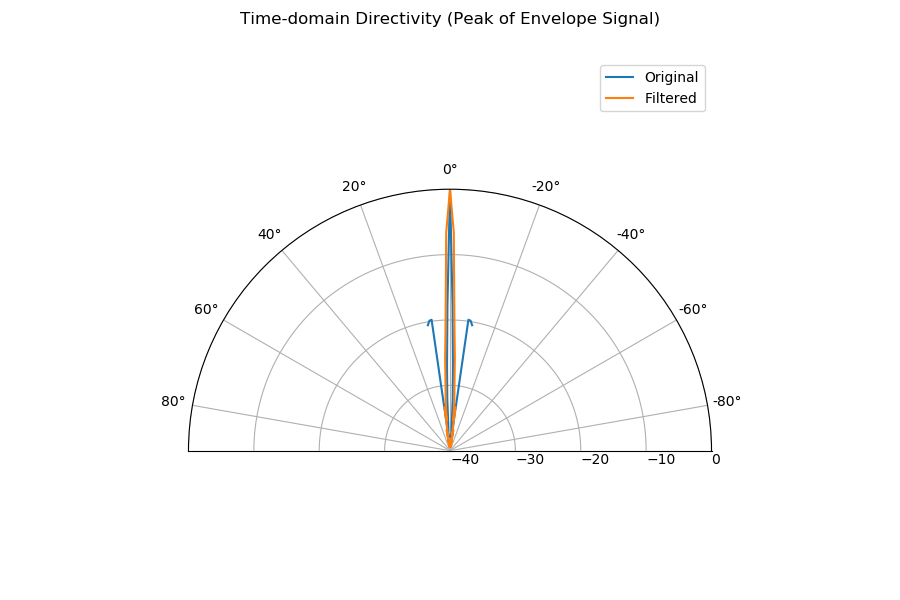

In [6]:
def convert_to_2sided(f, s):
    
    s = np.atleast_2d(s)
    
    npos, nf = s.shape
    nfft = (nf - 1)*2

    s2s = np.zeros((npos, nfft), dtype=np.complex128)
    s2s[:, :nfft//2] = s[:, :-1]
    s2s[:, nfft//2:] = np.conj(s[:, -1:0:-1])

    df = f[1] - f[0]
    fs = df*nfft 
    f2s = fftfreq(nfft, 1/fs)
    
    return f2s, s2s.squeeze()


def envelope(s, axis=-1):
    return np.abs(sp.signal.hilbert(s, axis=axis))


freqs2s, dr2s = convert_to_2sided(freqs, dr)

drt = np.real(ifft(dr2s, axis=1))
drt_filt = sp.signal.lfilter(b, a, drt, axis=1)
fs = (freqs[1] - freqs[0])*nfreqs*2
t = np.arange(drt.shape[1])/fs

drt_env = envelope(drt)
drt_filt_env = envelope(drt_filt)

drt_max = np.max(drt_env, axis=1)
drt_filt_max = np.max(drt_filt_env, axis=1)

d1 = 20 * np.log10(drt_max/drt_max.max())
d2 = 20 * np.log10(drt_filt_max/drt_filt_max.max())
    
d1[d1 < -60] = -60
d2[d2 < -60] = -60

theta = np.deg2rad(rangles)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='polar')
ax.plot(theta, d1)
ax.plot(theta, d2)
ax.set_rlim(-40, 0)
ax.set_rticks([-40, -30, -20, -10, 0])
ax.set_theta_zero_location('N')
ax.set_thetamin(-90)
ax.set_thetamax(90)
plt.title('Time-domain Directivity (Peak of Envelope Signal)')
plt.legend(['Original','Filtered'])
plt.tight_layout()



<IPython.core.display.Javascript object>


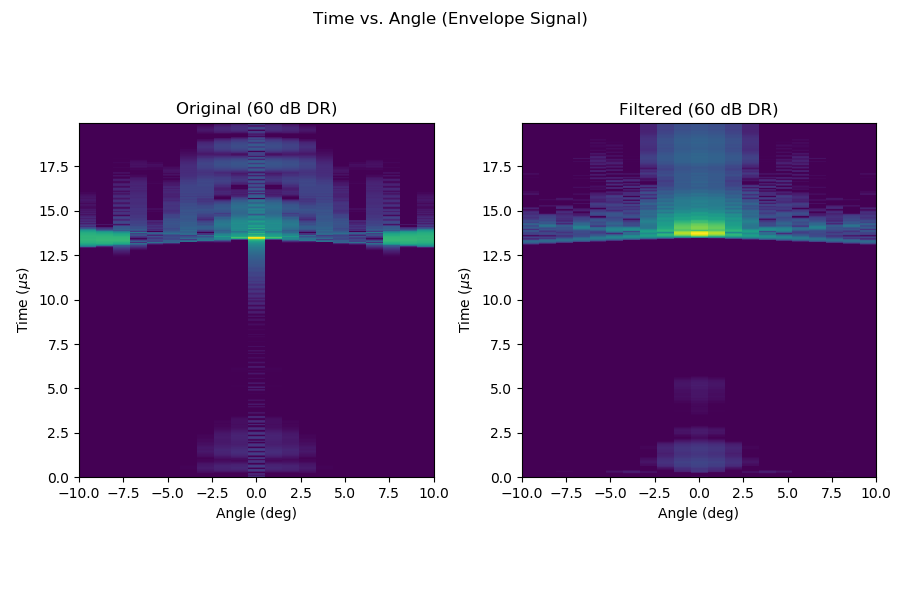

In [7]:
from matplotlib.gridspec import GridSpec

env1 = 20 * np.log10(drt_env/drt_env.max())
env2 = 20 * np.log10(drt_filt_env/drt_filt_env.max())
env1[env1 < -60] = -60
env2[env2 < -60] = -60

angles_range = rangles[-1] - rangles[0]
t_range = (t[-1] - t[0])/1e-6

fig = plt.figure(figsize=(9,6))
plt.suptitle('Time vs. Angle (Envelope Signal)')
gs = GridSpec(1,2)
ax = fig.add_subplot(gs[0,0], aspect='equal')
im = ax.imshow(env1.T, extent=(rangles[0], rangles[-1], t[0]/1e-6, t[-1]/1e-6), 
          aspect=angles_range/t_range, origin='lower')
ax.set_xlabel('Angle (deg)')
ax.set_ylabel('Time ($\mu$s)')
ax.set_title('Original (60 dB DR)')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.1)
# cbar = fig.colorbar(im, cax=cax, orientation='vertical')

ax = fig.add_subplot(gs[0,1])
im = ax.imshow(env2.T, extent=(rangles[0], rangles[-1], t[0]/1e-6, t[-1]/1e-6),
               aspect=angles_range/t_range, origin='lower')
ax.set_xlabel('Angle (deg)')
ax.set_ylabel('Time ($\mu$s)')
ax.set_title('Filtered (60 dB DR)')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.1)
# cbar = fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()


<IPython.core.display.Javascript object>


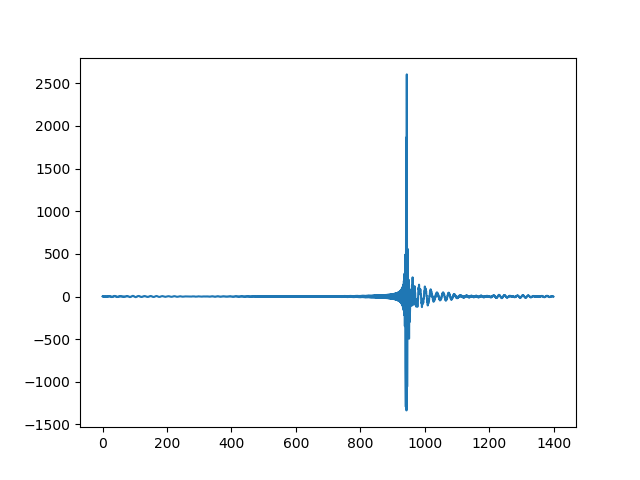

In [18]:
plt.figure()
plt.plot(drt[10,:])